In [1]:
from collections import Counter

import matplotlib.pyplot as plt

In [2]:
# TODO: Change the paths and the names of the files you want to create word clouds for
NEWS = {
  "path": "./news/news.txt",
  "name": "news"
}
BIBLE = {
  "path": "./bible/preprocessed/preprocessed_text.txt",
  "name": "bible"
}
WIKI_TL = {
  "path": "./wiki_tl/preprocessed_wiki_tl.txt",
  "name": "wiki tagalog"
}

dataset = [NEWS, BIBLE, WIKI_TL]

In [3]:
def get_top_n_ngrams(filename, n, ngram_sizes):
    with open(filename, "r", encoding="cp1252") as f:
        text = f.read()
    words = text.split()
    all_ngrams = {}
    for ngram_size in ngram_sizes:
        ngrams = []
        for i in range(len(words) - ngram_size + 1):
            ngram = tuple(words[i:i+ngram_size])
            ngrams.append(ngram)
        all_ngrams[ngram_size] = Counter(ngrams).most_common(n)
    return all_ngrams

In [4]:
ngrams_names = {2: "bigrams", 3: "trigrams", 4: "quadgrams", 5: "pentagrams", 6: "hexagrams", 7: "heptagrams", 8: "octagrams", 9: "nonagrams", 10: "decagrams"}


def display_ngram(ngram_size, ngram, source):
   ngram = sorted(ngram, key=lambda x: x[1], reverse=True)
   labels, values = zip(*ngram)
   labels = [ " ".join(ngram) for ngram in labels ]
   indexes = range(len(labels))

   plt.barh(indexes, values, align='center')

   plt.yticks(indexes, labels)

   plt.ylabel(ngrams_names[ngram_size])

   plt.xlabel("Frequency")

   plt.title(f"{source} {ngrams_names[ngram_size]}")

   plt.gca().invert_yaxis()
   plt.show() 

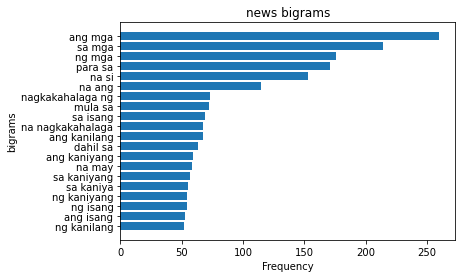

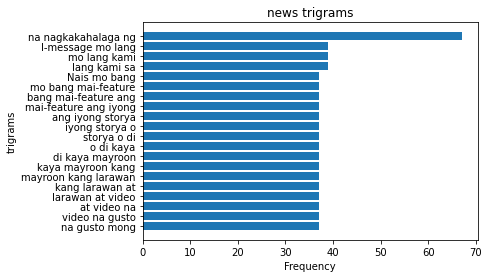

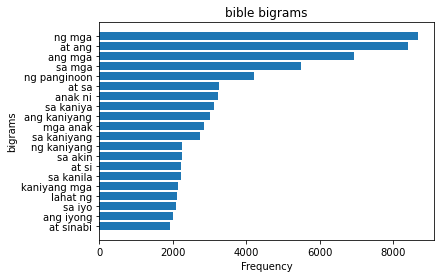

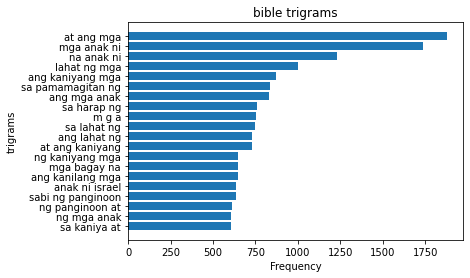

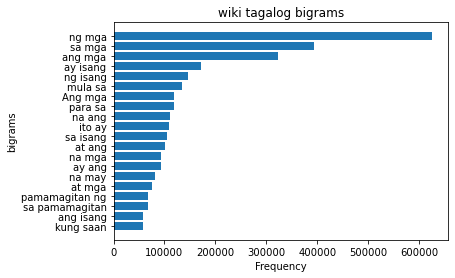

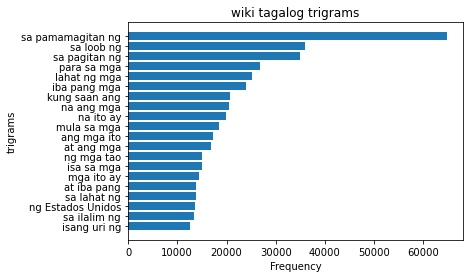

In [5]:
ngram_sizes =  [2,3] # Bigram and Trigram

for source in dataset:
   ngrams = get_top_n_ngrams(source["path"],20, ngram_sizes)
   for i, ngram in enumerate(ngrams):
      display_ngram(ngram_size=ngram_sizes[i], ngram=ngrams[ngram_sizes[i]], source=source["name"])

